In [10]:
# path

neologd_dict_path = '/usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd'
font_path = "/usr/share/fonts/truetype/takao-gothic/TakaoGothic.ttf"
blog_save_dir = '/keyakizaka_mining/data/blog'
fasttext_model_save_dir = '/keyakizaka_mining/model/fasttext'

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

from gensim.models import FastText
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [12]:
# cloudpickle

import cloudpickle

def load_from_pkl( fpath ):
    frb = open(fpath, 'rb')
    obj = cloudpickle.loads(frb.read())
    return onj

def save_as_pkl( obj, fpath ):
    fwb = open( fpath, 'wb')
    tmp = fwb.write(cloudpickle.dumps(obj))
    return

In [13]:
# japanese NLP

import MeCab
mecab = MeCab.Tagger (r"-Ochasen -d %s" % neologd_dict_path)

import re, unicodedata
import neologdn

def clean_text(text):
    replaced_text = text.lower()
    replaced_text = re.sub(r'[【】]', ' ', replaced_text)       # 【】の除去
    replaced_text = re.sub(r'[（）()]', ' ', replaced_text)     # （）の除去
    replaced_text = re.sub(r'[［］\[\]]', ' ', replaced_text)   # ［］の除去
    replaced_text = re.sub(r'[@＠]\w+', '', replaced_text)  # メンションの除去
    replaced_text = re.sub(r'https?:\/\/.*?[\r\n ]', '', replaced_text)  # URLの除去
    replaced_text = re.sub(r'　', ' ', replaced_text)  # 全角空白の除去
    return replaced_text

def normalize_text( text ):
    text = neologdn.normalize(text)
    text = normalize_number(text)    
    return text

def normalize_number(text):
    replaced_text = re.sub(r'\d+', '0', text)
    return replaced_text

def get_tokens_pos( text, target_pos ):
    tokens = []
    for line in mecab.parse( text ).split('\n')[:-2]:
        line = line.split('\t')
        pos = line[3].split('-')[0]
        if pos in target_pos: tokens.append( line[2] )
    return tokens

In [30]:
# japanese plot setting

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

font_prop = FontProperties(fname=font_path)
mpl.rcParams['font.family'] = font_prop.get_name()

In [15]:
# read blog data

df = pd.read_csv( '%s/keyakizaka46_blog_20190217.csv' % (blog_save_dir) )
print( df.shape )

(16754, 6)


In [16]:
# get input text

sentences = []
for idx, text in enumerate( df['text'].values ):
    if idx % 1000 == 0: print( idx )
    text = clean_text(text)
    text = unicodedata.normalize('NFC', text)
    text = neologdn.normalize(text, repeat=1)
    tokens = get_tokens_pos( text, ['名詞', '動詞', '形容詞'] )
    sentences.append( tokens )
save_as_pkl( sentences, '%s/keyakizaka_blog_nva_sentences.pkl' % (blog_save_dir) )

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000


In [17]:
# learn fasttext

model = FastText(size=100, sg=1, workers=7, window=10, min_count=10)
model.build_vocab(sentences)
model.train(sentences, total_examples=model.corpus_count, epochs=model.epochs)

In [18]:
# save model

model.save( '%s/keyakizaka_blog_nva.model' % fasttext_model_save_dir )

In [19]:
# test

# model.wv.vocab
model.wv.most_similar("佐々木久美")

[('久美', 0.6432363986968994),
 ('加藤史帆', 0.6425693035125732),
 ('東村', 0.6028094291687012),
 ('柿崎', 0.6003142595291138),
 ('きくちゃん', 0.5992032885551453),
 ('加藤', 0.5749603509902954),
 ('佐々木', 0.5704282522201538),
 ('東村芽依', 0.557314932346344),
 ('齊藤', 0.5533276796340942),
 ('ジェダイ', 0.5449005365371704)]

In [20]:
model.wv.most_similar("キャプテン")

[('就任', 0.6935394406318665),
 ('テン', 0.6371507048606873),
 ('ドリームチーム', 0.6204546689987183),
 ('菅井友香', 0.6169405579566956),
 ('頼もしい', 0.6130880117416382),
 ('最年長', 0.6030646562576294),
 ('頼る', 0.5989840030670166),
 ('重大発表', 0.5985387563705444),
 ('話し合い', 0.5970480442047119),
 ('ゆか', 0.5847855806350708)]

In [21]:
model.wv.most_similar("てち")

[('平手', 0.6624051332473755),
 ('平手友梨奈', 0.628106951713562),
 ('今泉佑唯', 0.6084874868392944),
 ('友梨奈', 0.5990333557128906),
 ('図画', 0.5983281135559082),
 ('りさ', 0.5975528359413147),
 ('あか', 0.595596194267273),
 ('べりさ', 0.5947811603546143),
 ('波布茶', 0.5939778089523315),
 ('づぅ', 0.5869863033294678)]

In [22]:
# omake

In [23]:
def plot_with_label( X_tmp, y_tmp, d1, d2 ): # , groups
    fig = plt.figure(figsize=(6,4),dpi=200)
    plt.scatter(X_tmp[:, d1], X_tmp[:, d2], alpha=0.5)

    for i, cat in enumerate( y_tmp ):
        plt.annotate( s=cat, xy=(X_tmp[i, d1],X_tmp[i, d2]), ha='right', va='bottom',
            bbox=dict(boxstyle='round, pad=0.05', fc='orange', alpha=0.6),fontsize=6,
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    
    plt.show()

In [24]:
member_list = df['author'].unique().tolist()
member_list = member_list + ['土田', '澤部', '春日', '若林']

In [25]:
# fasttext features

X = np.zeros( ( len(member_list), 100 ) )
for i, m in enumerate( member_list ):
    X[i] = model.wv[m]
# X[np.isnan(X)] = 0.0

In [28]:
# dimensionality reduction

# pca = PCA(); pca.fit(X); Xr = pca.fit_transform( X )
Xr = TSNE(n_components=2, perplexity=8, random_state=0).fit_transform( X )

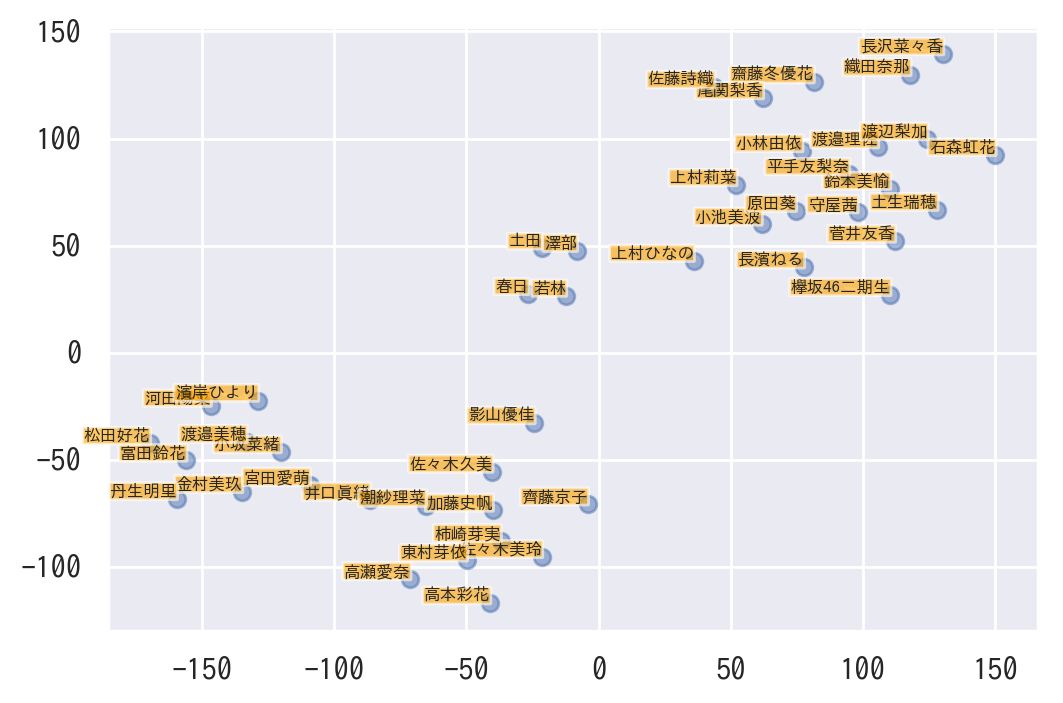

In [31]:
plot_with_label( Xr, member_list, 0, 1 )